In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# Data prep

In [48]:
data = pd.read_csv("../0.Data/questions.csv")
data = data.iloc[:,3:]
data['question1'] = data['question1'].apply(lambda x: str(x))
data['question2'] = data['question2'].apply(lambda x: str(x))

sents = data['question1'].values.tolist()
sents.extend(data['question2'].values.tolist())

tokenizer = tf.keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(sents)
data['q1_tokenized'] = tokenizer.texts_to_sequences(data['question1'])
data['q2_tokenized'] = tokenizer.texts_to_sequences(data['question2'])


In [91]:
tokenizer.document_count

808702

Max lenth of sequences chosen:  75


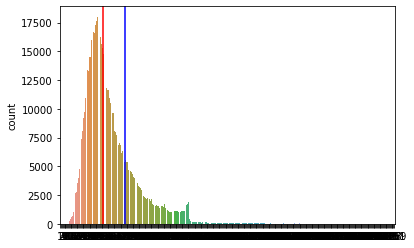

In [3]:
plt.axvline(50, c='red')
plt.axvline(75, c='blue')
sns.countplot(pd.Series([len(x) for x in sents]))
MAX_LEN = 75
print("Max lenth of sequences chosen: ", MAX_LEN)

In [27]:
def pad_sequences(text):

    if len(text) <= MAX_LEN:
        text.extend([0]*(MAX_LEN - len(text)))
    else:
        text = text[:MAX_LEN]

    return text

In [49]:
data['q1_tokenized'] = data['q1_tokenized'].apply(pad_sequences)
data['q2_tokenized'] = data['q2_tokenized'].apply(pad_sequences)

In [60]:
tokenized_data = np.array([np.stack(data['q1_tokenized']), np.stack(data['q1_tokenized'])])
tokenized_data = tokenized_data.swapaxes(0,1)

(2, 404351, 75)

In [71]:
X_train, X_test, y_train, y_test = train_test_split(tokenized_data, data['is_duplicate'], stratify=data['is_duplicate'], random_state=42, test_size=0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, test_size=0.1, stratify=y_train)

In [76]:
y_train = y_train.values.reshape(-1,1)
y_val = y_val.values.reshape(-1,1)
y_test = y_test.values.reshape(-1,1)

In [77]:
trainset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size=64).shuffle(buffer_size=5)
validationset = tf.data.Dataset.from_tensor_slices((X_val,y_val)).batch(batch_size=64)
testset = tf.data.Dataset.from_tensor_slices((X_train,y_train)).batch(batch_size=64)

# Model

In [125]:
class sim_model(tf.keras.Model):

    def __init__(self,):
        
        super(sim_model,self).__init__()

        self.emb = tf.keras.layers.Embedding(input_dim = tokenizer.document_count, output_dim = 64)

        self.lstm1 = tf.keras.layers.LSTM(50, return_sequences = True)
        self.lstm2 = tf.keras.layers.LSTM(50, return_sequences = True)

        self.fc1 = tf.keras.layers.Dense(32, activation='leaky_relu')
        self.fc2 = tf.keras.layers.Dense(32, activation='leaky_relu')

    def call(self, x1, x2, h1i = None, h2i = None):

        embx1 = self.emb(x1)
        embx2 = self.emb(x2)
        print(embx1.shape)

        seqx1, h1o = self.lstm1(embx1, h1i)
        seqx2, h2o = self.lstm2(embx2, h2i)
        print(seqx1.shape)

        fcx1 = self.fc1(seqx1)
        fcx2 = self.fc2(seqx2)
        print(fcx1.shape)

        return fcx1, fcx2, h1o, h2o

In [126]:
similarity_model = sim_model()

In [127]:
similarity_model(next(iter(trainset))[0][0], next(iter(trainset))[0][1])

(2, 75, 64)
(75, 50)
(75, 32)


(<tf.Tensor: shape=(75, 32), dtype=float32, numpy=
 array([[-1.7020488e-03,  2.9979243e-03,  8.4828418e-03, ...,
          8.1074499e-03, -7.9630216e-04,  4.1030631e-03],
        [ 1.6887792e-03, -1.3476536e-03, -3.7773654e-03, ...,
          3.5375364e-05,  1.0218750e-02, -2.1396931e-03],
        [ 4.3395557e-03,  4.9573067e-03, -3.6092286e-03, ...,
          1.5521098e-02,  3.5157355e-03, -2.5501493e-03],
        ...,
        [ 7.0608086e-03, -1.9564661e-03, -6.2170136e-03, ...,
          7.7043162e-03, -3.3679788e-03,  1.1281302e-02],
        [ 7.0608114e-03, -1.9564668e-03, -6.2170145e-03, ...,
          7.7043176e-03, -3.3679779e-03,  1.1281304e-02],
        [ 7.0608058e-03, -1.9564654e-03, -6.2170131e-03, ...,
          7.7043148e-03, -3.3679791e-03,  1.1281300e-02]], dtype=float32)>,
 <tf.Tensor: shape=(75, 32), dtype=float32, numpy=
 array([[-0.00170205,  0.00299792,  0.00848284, ...,  0.00810745,
         -0.0007963 ,  0.00410306],
        [-0.00293617,  0.00361504,  0.0046041

In [88]:
model.compile(
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=1e-4),
    metrics = 'accuracy',
    loss = tf.keras.losses.BinaryCrossentropy()
)

In [89]:
model.fit(trainset,
epochs=10,
validation_data = validationset,
callbacks = [tf.keras.callbacks.EarlyStopping(patience=5, monitor='val_loss')]
)

Epoch 1/10


ValueError: in user code:

    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 878, in train_function  *
        return step_function(self, iterator)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 867, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 860, in run_step  **
        outputs = model.train_step(data)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/training.py", line 808, in train_step
        y_pred = self(x, training=True)
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/utils/traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "/opt/homebrew/Caskroom/miniforge/base/envs/tensorflow_env/lib/python3.9/site-packages/keras/engine/input_spec.py", line 213, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" '

    ValueError: Exception encountered when calling layer "sequential_2" (type Sequential).
    
    Input 0 of layer "bidirectional_2" is incompatible with the layer: expected ndim=3, found ndim=4. Full shape received: (None, 2, 75, 75)
    
    Call arguments received:
      • inputs=tf.Tensor(shape=(None, 2, 75), dtype=int64)
      • training=True
      • mask=None


In [90]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 75)          7500000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               27648     
 nal)                                                            
                                                                 
 dense_8 (Dense)             (None, 64)                4160      
                                                                 
 dense_9 (Dense)             (None, 128)               8320      
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_10 (Dense)            (None, 32)                4128      
                                                      